<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%84%9C%EC%9A%B8%EB%9E%9C%EB%93%9C%EB%A7%88%ED%81%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울 랜드마크 이미지 분류 경진대회

## 데이터 불러오기

In [27]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`-` 런타임 재시작

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import cv2
import os
import gc

from tqdm.notebook import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data/dataset.zip'

In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류


- 데이터 불러오기

In [6]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

- 하이퍼파라미터

In [7]:
MODEL_NAME = 'convmixer'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
SAVE_PATH = './weight'
NUM_CLASSES = 10
NUM_FOLDS = 5
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 6e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
SEED = 2022

- 가중치 저장폴더

In [8]:
def create_folder(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [9]:
create_folder(SAVE_PATH)

- 이미지 불러오기

In [10]:
def load_images(path, format='png'):
    images = []
    images_path = path + f'/*.{format}'

    for image_path in tqdm(sorted(glob(images_path))): ## path에 들어있는 format 형식을 가진 파일을 검색(1번부터 차례대로 검색해야 된다)
        image = cv2.imread(image_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_LINEAR) 
        images.append(image)  
    
    images = np.array(images).astype(np.float32)
    return images

In [11]:
train_images = load_images(path='./Data/train', format='PNG')
test_images = load_images(path='./Data/test', format='PNG')

  0%|          | 0/723 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [12]:
train_images.shape, test_images.shape

((723, 240, 240, 3), (199, 240, 240, 3))

## 시각화

- 이미지

In [15]:
def show_random_images(images, labels, nrows=3, ncols=3):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    idx_list = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for idx, ax in zip(idx_list, axs.flatten()):
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[idx])
        ax.imshow(images[idx])       
    fig.tight_layout()

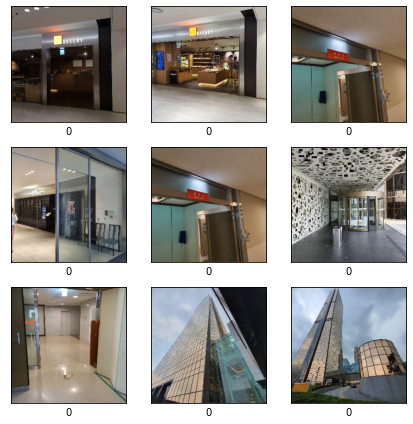

In [16]:
show_random_images(train_images[df.query('label == 0').index].astype(np.uint8), [0]*1000)

`-` 클래스 0은 외부에서 찍은 사진과 내부에서 찍은 사진으로 나뉜다

`-` 외부에서 찍은 사진은 비교적 일관적이지만 내부에서 찍은 사진은 제각각이다

`-` 적절한 라벨스무딩이 필요할 듯 하다

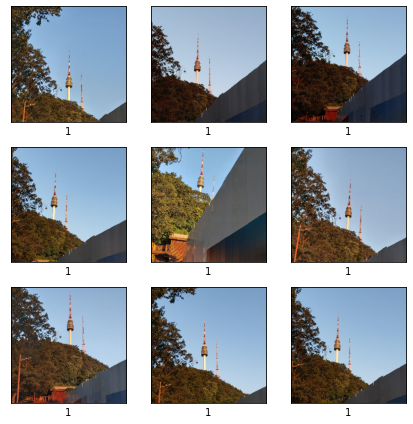

In [18]:
show_random_images(train_images[df.query('label == 1').index].astype(np.uint8), [1]*1000) 

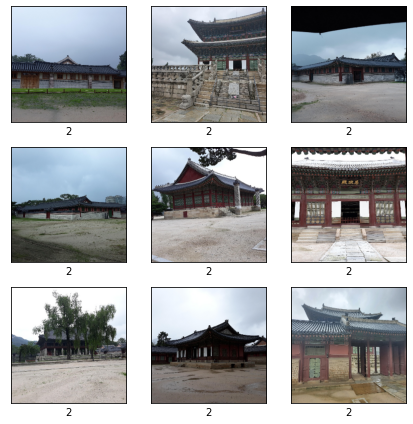

In [19]:
show_random_images(train_images[df.query('label == 2').index].astype(np.uint8), [2]*1000)

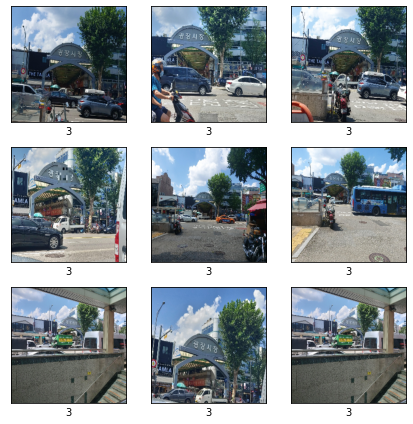

In [20]:
show_random_images(train_images[df.query('label == 3').index].astype(np.uint8), [3]*1000)

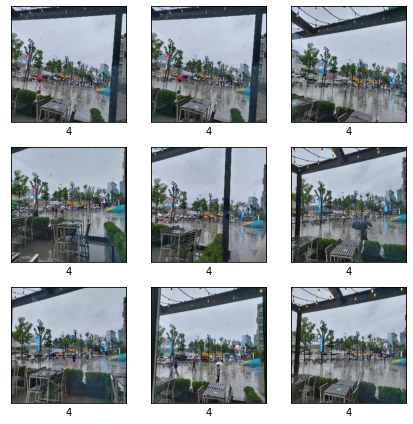

In [21]:
show_random_images(train_images[df.query('label == 4').index].astype(np.uint8), [4]*1000)

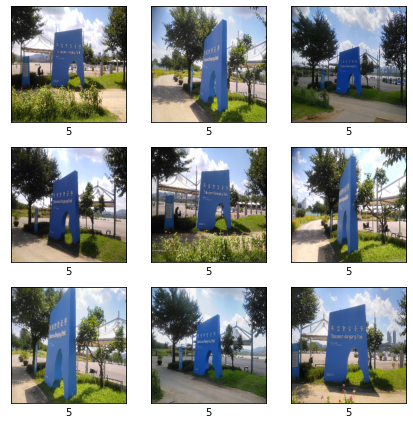

In [22]:
show_random_images(train_images[df.query('label == 5').index].astype(np.uint8), [5]*1000)

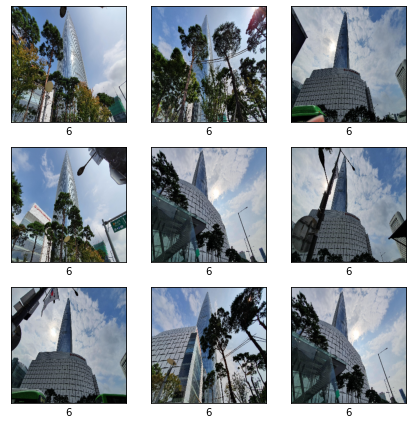

In [23]:
show_random_images(train_images[df.query('label == 6').index].astype(np.uint8), [6]*1000)

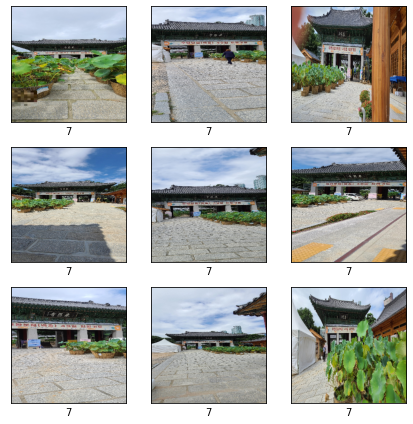

In [24]:
show_random_images(train_images[df.query('label == 7').index].astype(np.uint8), [7]*1000)

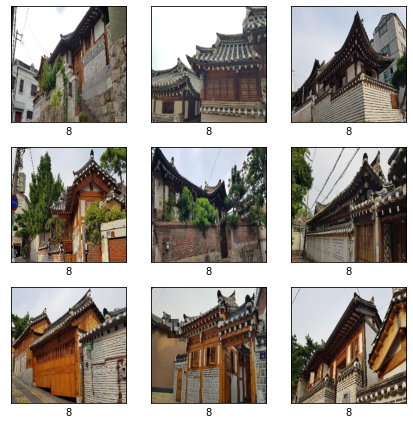

In [25]:
show_random_images(train_images[df.query('label == 8').index].astype(np.uint8), [8]*1000)

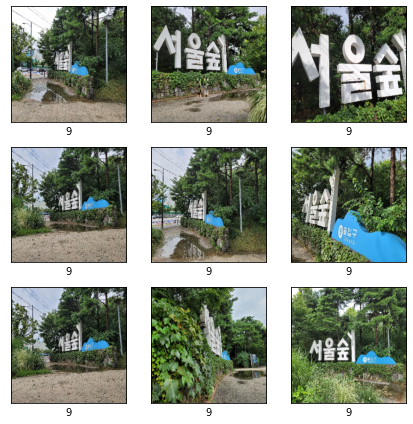

In [26]:
show_random_images(train_images[df.query('label == 9').index].astype(np.uint8), [9]*1000)

- 라벨

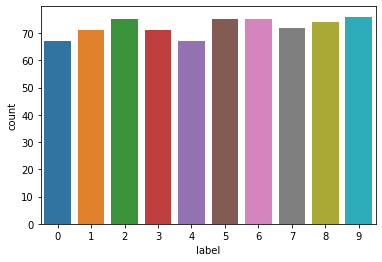

In [17]:
sns.countplot(data=df, x='label')

`-` 라벨별 개수는 비슷하다

## 모델 학습 준비

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [30]:
## 정확도 계산
def accuracy(true, pred):
    return np.sum(true == pred) / len(true)

In [31]:
def seed_everything(seed=22):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [32]:
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

- 데이터 셋과 데이터 로더

In [33]:
class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)  

In [34]:
def get_dataloader(X, y=None, transforms=None, shuffle_dataloader=True):
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

In [35]:
RGB_MEAN = [np.mean((train_images[..., i])) / 255 for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) / 255 for i in range(3)]  

In [36]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(train_mode=True):
    transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
        ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch.Tensor로 변환 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.CenterCrop(224, 224),   
            A.Perspective(scale=0.2, p=0.5),
            A.Rotate(limit=25, p=0.5),  
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
            ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch.Tensor로 변환  
        ])

    return transforms  ## 데이터 변환 방식을 반환

`-` 색을 바꾸면 클래스 0과 6을 구분하기 힘들다

`-` 그래서 색을 변형시키는 변환은 사용하지 않겠다

In [37]:
target = df['label'].values

- 딥러닝 모델

In [38]:
## Copyright (c) 2021 Author(s) of ICLR 2022 Submission "Patches Are All You Need?"
## 코드: https://github.com/locuslab/convmixer/blob/main/convmixer.py
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, num_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding='same'),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, num_classes)
    )

- 가중치 초기화

In [39]:
## layer 가중치 초기화
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:
        n = model.in_features
        nn.init.normal_(model.weight.data, 0.0, np.sqrt(2 / n))
        nn.init.constant_(model.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

- 조기 중단

In [40]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """patience 횟수 에폭 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
                      'accuracy',
                    ]

    def __init__(self, patience=7, monitored_quantity='loss', mode='min', min_delta=0.0, path='./weight', model_name='', current_fold=1):
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitored_quantity (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitored_quantity = monitored_quantity
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(self, model, valid_loss, valid_metric_score=None):
        ## score는 클수록 좋다
        if self.monitored_quantity == 'loss':
            score = valid_loss * self.direction
        elif self.monitored_quantity in self.score_metrics:
            score = valid_metric_score * self.direcion
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(self, model, valid_loss, valid_metric_score=None):
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def check_early_stop(self):
        return self.early_stop

    def set_fold(self, current_fold):
        self.current_fold = current_fold

    def reset_score(self):
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

## 모델 K겹 교차검증

In [41]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [42]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [43]:
early_stopping = EarlyStopping(patience=20,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

- 모델 교차검증 관련 함수

In [44]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_loss

In [45]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 평균 배치 검증 오차와 정확도를 반환"""
    valid_acc, valid_loss = 0.0, 0.0  ## mini-batch 평균 검증 오차와 정확도 
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  
            acc = accuracy(y.cpu().numpy(), y_hat.cpu().numpy().argmax(-1))    
            valid_loss += loss.item() / len(dataloader)
            valid_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)

    return valid_loss, valid_acc

In [47]:
def kfold_cross_validate(model, X, y, skfold, loss_fn, early_stopping):
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_loss = []  ## 폴드별 가장 작은 검증 손실
    fold_valid_acc = []  ## 폴드별 가장 작은 검증 손실을 가질 때의 정확도
    fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        ## 메모리 절약
        clear_gpu()
        
        ## 훈련 데이터와 검증 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]
        y_train = torch.tensor(y_train, dtype=torch.int64)   
        y_valid = torch.tensor(y_valid, dtype=torch.int64)   

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms(train_mode=True))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms(train_mode=False))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device)) 

        ## optimizer, scheduler (수동으로 선택)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) 
        scheduler = None

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS + 1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == NUM_EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_acc)  ## __call__ function
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  ## 폴드별 가장 작은 검증 손실
        fold_valid_acc.append(early_stopping.valid_metric_score)  ## 폴드별 가장 작은 검증 손실일 때의 정확도
         
        ## 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 정확도를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid Accuracy: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 정확도를 출력
    print(f'{num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_acc):.5f}')

    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 모델 선언 및 초기화시킨 가중치 저장

In [49]:
seed_everything(SEED)
model = ConvMixer(dim=2**7, depth=8, kernel_size=7, patch_size=7, num_classes=NUM_CLASSES)
model.apply(init_weights)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

- 모델 K겹 교차검증

In [50]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.29980  valid loss = 0.98076  valid acc = 0.67586
[Epoch: 10]  train loss = 0.42882  valid loss = 0.52501  valid acc = 0.95172
[Epoch: 20]  train loss = 0.36989  valid loss = 0.38673  valid acc = 0.97931
[Epoch: 30]  train loss = 0.38398  valid loss = 0.36797  valid acc = 0.99310
[Epoch: 40]  train loss = 0.35380  valid loss = 0.37514  valid acc = 0.97931
[Epoch: 50]  train loss = 0.34918  valid loss = 0.36928  valid acc = 0.97931
[Epoch: 60]  train loss = 0.39478  valid loss = 0.34983  valid acc = 0.98621
[Epoch: 70]  train loss = 0.34628  valid loss = 0.37973  valid acc = 0.98621
[Epoch: 80]  train loss = 0.32983  valid loss = 0.33012  valid acc = 1.00000
[Epoch: 82]  train loss = 0.34912  valid loss = 0.33209  valid acc = 0.98621
Early Stopping!
1 Fold -> Best Valid Loss: 0.32850 Valid Accuracy: 1.00000

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.26493  valid loss = 1.18604  valid acc = 0.65517
[Epoch: 10]  train loss = 0.41579  valid loss = 0.41007  valid acc = 0.98621
[Epoch: 20]  train loss = 0.39410  valid loss = 0.40197  valid acc = 0.97931
[Epoch: 30]  train loss = 0.37282  valid loss = 0.38264  valid acc = 0.95862
[Epoch: 40]  train loss = 0.34537  valid loss = 0.37989  valid acc = 0.97931
[Epoch: 50]  train loss = 0.34418  valid loss = 0.36676  valid acc = 0.97241
[Epoch: 60]  train loss = 0.33765  valid loss = 0.37482  valid acc = 0.97241
[Epoch: 70]  train loss = 0.33157  valid loss = 0.35735  valid acc = 0.97241
[Epoch: 80]  train loss = 0.33182  valid loss = 0.36177  valid acc = 0.97931
[Epoch: 90]  train loss = 0.37839  valid loss = 0.34847  valid acc = 0.97241
[Epoch: 100]  train loss = 0.34004  valid loss = 0.36762  valid acc = 0.97241
2 Fold -> Best Valid Loss: 0.33137 Valid Accuracy: 0.97931

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.27885  valid loss = 0.88202  valid acc = 0.80000
[Epoch: 10]  train loss = 0.43050  valid loss = 0.47908  valid acc = 0.93103
[Epoch: 20]  train loss = 0.39339  valid loss = 0.38709  valid acc = 0.98621
[Epoch: 30]  train loss = 0.36054  valid loss = 0.38360  valid acc = 0.98621
[Epoch: 40]  train loss = 0.39430  valid loss = 0.35280  valid acc = 0.97931
[Epoch: 50]  train loss = 0.34915  valid loss = 0.36497  valid acc = 0.97931
[Epoch: 60]  train loss = 0.32280  valid loss = 0.32530  valid acc = 0.99310
[Epoch: 70]  train loss = 0.33993  valid loss = 0.34559  valid acc = 0.98621
[Epoch: 79]  train loss = 0.35085  valid loss = 0.37429  valid acc = 0.99310
Early Stopping!
3 Fold -> Best Valid Loss: 0.32368 Valid Accuracy: 0.99310

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.30915  valid loss = 1.00259  valid acc = 0.73611
[Epoch: 10]  train loss = 0.38712  valid loss = 0.43967  valid acc = 0.97222
[Epoch: 20]  train loss = 0.37456  valid loss = 0.41971  valid acc = 0.95833
[Epoch: 30]  train loss = 0.35776  valid loss = 0.39511  valid acc = 0.97222
[Epoch: 40]  train loss = 0.40687  valid loss = 0.40773  valid acc = 0.96528
[Epoch: 50]  train loss = 0.33517  valid loss = 0.37881  valid acc = 0.98611
[Epoch: 60]  train loss = 0.34996  valid loss = 0.37231  valid acc = 0.98611
[Epoch: 70]  train loss = 0.32804  valid loss = 0.38201  valid acc = 0.98611
[Epoch: 80]  train loss = 0.31786  valid loss = 0.35145  valid acc = 0.98611
[Epoch: 90]  train loss = 0.32897  valid loss = 0.37248  valid acc = 0.97917
[Epoch: 100]  train loss = 0.31562  valid loss = 0.36856  valid acc = 0.97222
4 Fold -> Best Valid Loss: 0.34182 Valid Accuracy: 0.97917

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.27497  valid loss = 1.08673  valid acc = 0.70139
[Epoch: 10]  train loss = 0.40054  valid loss = 0.40998  valid acc = 0.98611
[Epoch: 20]  train loss = 0.38525  valid loss = 0.34848  valid acc = 0.98611
[Epoch: 30]  train loss = 0.34637  valid loss = 0.36616  valid acc = 0.99306
[Epoch: 40]  train loss = 0.34103  valid loss = 0.34569  valid acc = 0.98611
[Epoch: 50]  train loss = 0.32819  valid loss = 0.34548  valid acc = 0.99306
[Epoch: 60]  train loss = 0.33498  valid loss = 0.34913  valid acc = 0.97917
[Epoch: 70]  train loss = 0.32109  valid loss = 0.33106  valid acc = 0.99306
[Epoch: 80]  train loss = 0.33282  valid loss = 0.32120  valid acc = 0.99306
[Epoch: 90]  train loss = 0.31166  valid loss = 0.33373  valid acc = 0.99306
[Epoch: 100]  train loss = 0.34311  valid loss = 0.33682  valid acc = 0.99306
5 Fold -> Best Valid Loss: 0.31259 Valid Accuracy: 1.00000

5 Fold Mean Valid Best Loss: 0.32759
5 Fold Mean Valid Accuracy: 0.99032


- train loss와 valid loss의 변화를 시각화

In [51]:
def show_loss_plot(fold_train_losses, fold_valid_losses):
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (train_losses, valid_losses, ax) in enumerate(zip(fold_train_losses, fold_valid_losses, axes.flatten()), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs + 1), train_losses, label='Train')
        ax.plot(range(1, num_epochs + 1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

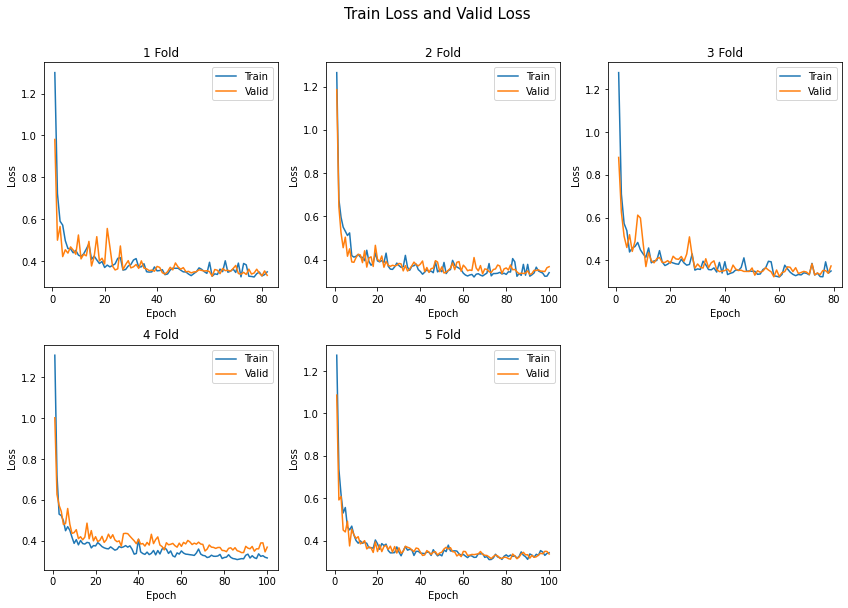

In [52]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

## Test 예측

In [53]:
def predict(model, dataloader, weight_save_path, return_prob=False):
    """저장된 모델의 가중치를 불러온 후 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        if MODEL_NAME not in weight_path:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device)
                y_hat = model(X).cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [54]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms(train_mode=False), shuffle_dataloader=False)

In [55]:
test_preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
submission['label'] = test_preds
submission.head()

,file_name,label
0,001.PNG,7
1,002.PNG,1
2,003.PNG,9
3,004.PNG,7
4,005.PNG,6


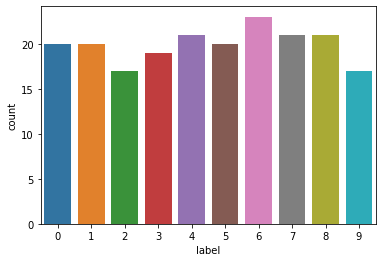

In [57]:
sns.countplot(data=submission, x='label')

In [58]:
# submission.to_csv(f'./Data/submission-{MODEL_NAME}.csv', index=False)